# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [6]:
# util.load_hopskey()

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
yesterday = today - datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 17, 10, 56, 20, 762319)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [ ]:
# os.environ["HOPSWORKS_API_KEY"] = ""
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1160345
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [6]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=3,
)
feature_view_1 = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [7]:
mr = project.get_model_registry()

retrieved_model_1 = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=3,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()
saved_model_dir_1 = retrieved_model_1.download()

Connected. Call `.close()` to terminate connection gracefully.


In [8]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='1.072271E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [9]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model_1 = XGBRegressor()

retrieved_xgboost_model_1.load_model(saved_model_dir_1 + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model_1

XGBRegressor(base_score='1.071918E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [10]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=3,
)
batch_data = weather_fg.filter(weather_fg.date >= yesterday ).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.09s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-17 00:00:00+00:00,7.70,0.6,28.496904,266.378571,Eimsbüttel
1,2024-11-18 00:00:00+00:00,5.55,0.0,22.331610,268.152435,Eimsbüttel
2,2024-11-19 00:00:00+00:00,1.00,1.6,28.442278,89.274796,Eimsbüttel
3,2024-11-20 00:00:00+00:00,4.25,0.0,23.795427,287.612671,Eimsbüttel
4,2024-11-21 00:00:00+00:00,2.50,0.0,23.224882,251.003250,Eimsbüttel
5,2024-11-22 00:00:00+00:00,1.95,0.0,24.216522,221.987137,Eimsbüttel
6,2024-11-23 00:00:00+00:00,1.70,0.0,14.182355,203.962494,Eimsbüttel
7,2024-11-24 00:00:00+00:00,9.15,0.1,33.190357,220.601212,Eimsbüttel
8,2024-11-25 00:00:00+00:00,7.30,0.0,11.609651,240.255203,Eimsbüttel
9,2024-11-26 00:00:00+00:00,4.50,1.2,21.166653,48.447491,Eimsbüttel


In [11]:
batch_data_1 = weather_fg.filter(weather_fg.date >= yesterday ).read()
batch_data_1

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.65s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-17 00:00:00+00:00,7.70,0.6,28.496904,266.378571,Eimsbüttel
1,2024-11-18 00:00:00+00:00,5.55,0.0,22.331610,268.152435,Eimsbüttel
2,2024-11-19 00:00:00+00:00,1.00,1.6,28.442278,89.274796,Eimsbüttel
3,2024-11-20 00:00:00+00:00,4.25,0.0,23.795427,287.612671,Eimsbüttel
4,2024-11-21 00:00:00+00:00,2.50,0.0,23.224882,251.003250,Eimsbüttel
5,2024-11-22 00:00:00+00:00,1.95,0.0,24.216522,221.987137,Eimsbüttel
6,2024-11-23 00:00:00+00:00,1.70,0.0,14.182355,203.962494,Eimsbüttel
7,2024-11-24 00:00:00+00:00,9.15,0.1,33.190357,220.601212,Eimsbüttel
8,2024-11-25 00:00:00+00:00,7.30,0.0,11.609651,240.255203,Eimsbüttel
9,2024-11-26 00:00:00+00:00,4.50,1.2,21.166653,48.447491,Eimsbüttel


In [12]:
# get the training feature group, becasee we need the last rolling mean
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=3,
)
air_quality_fg_1 = fs.get_feature_group(
    name='air_quality',
    version=1,
)
train_df = air_quality_fg.read().sort_values("date")
popped_value = train_df.iloc[-3]["pm25"]     # get the first value that contributest to the last rolling mean (-3 postition)
rolling_mean = train_df.iloc[-1]["pm25_lagging"]

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.32s) 


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [13]:
batch_data.sort_values("date", inplace=True)
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-17 00:00:00+00:00,7.70,0.6,28.496904,266.378571,Eimsbüttel
1,2024-11-18 00:00:00+00:00,5.55,0.0,22.331610,268.152435,Eimsbüttel
2,2024-11-19 00:00:00+00:00,1.00,1.6,28.442278,89.274796,Eimsbüttel
3,2024-11-20 00:00:00+00:00,4.25,0.0,23.795427,287.612671,Eimsbüttel
4,2024-11-21 00:00:00+00:00,2.50,0.0,23.224882,251.003250,Eimsbüttel
5,2024-11-22 00:00:00+00:00,1.95,0.0,24.216522,221.987137,Eimsbüttel
6,2024-11-23 00:00:00+00:00,1.70,0.0,14.182355,203.962494,Eimsbüttel
7,2024-11-24 00:00:00+00:00,9.15,0.1,33.190357,220.601212,Eimsbüttel
8,2024-11-25 00:00:00+00:00,7.30,0.0,11.609651,240.255203,Eimsbüttel
9,2024-11-26 00:00:00+00:00,4.50,1.2,21.166653,48.447491,Eimsbüttel


### Predictions for v1 ###

In [30]:
batch_data_1.sort_values("date", inplace=True)
batch_data_1['predicted_pm25'] = retrieved_xgboost_model_1.predict(
    batch_data_1[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data_1

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-17 00:00:00+00:00,7.70,0.6,28.496904,266.378571,Eimsbüttel,8.370222,Rentzelstraße,Germany,1
1,2024-11-18 00:00:00+00:00,5.55,0.0,22.331610,268.152435,Eimsbüttel,12.778295,Rentzelstraße,Germany,2
2,2024-11-19 00:00:00+00:00,1.00,1.6,28.442278,89.274796,Eimsbüttel,11.624334,Rentzelstraße,Germany,3
3,2024-11-20 00:00:00+00:00,4.25,0.0,23.795427,287.612671,Eimsbüttel,6.239011,Rentzelstraße,Germany,4
4,2024-11-21 00:00:00+00:00,2.50,0.0,23.224882,251.003250,Eimsbüttel,16.891090,Rentzelstraße,Germany,5
5,2024-11-22 00:00:00+00:00,1.95,0.0,24.216522,221.987137,Eimsbüttel,10.705856,Rentzelstraße,Germany,6
6,2024-11-23 00:00:00+00:00,1.70,0.0,14.182355,203.962494,Eimsbüttel,15.860163,Rentzelstraße,Germany,7
7,2024-11-24 00:00:00+00:00,9.15,0.1,33.190357,220.601212,Eimsbüttel,7.766912,Rentzelstraße,Germany,8
8,2024-11-25 00:00:00+00:00,7.30,0.0,11.609651,240.255203,Eimsbüttel,20.506159,Rentzelstraße,Germany,9
9,2024-11-26 00:00:00+00:00,4.50,1.2,21.166653,48.447491,Eimsbüttel,8.176023,Rentzelstraße,Germany,10


### Predictions for v3 ###

In [31]:
data = batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']]
data

,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,7.70,0.6,28.496904,266.378571
1,5.55,0.0,22.331610,268.152435
2,1.00,1.6,28.442278,89.274796
3,4.25,0.0,23.795427,287.612671
4,2.50,0.0,23.224882,251.003250
5,1.95,0.0,24.216522,221.987137
6,1.70,0.0,14.182355,203.962494
7,9.15,0.1,33.190357,220.601212
8,7.30,0.0,11.609651,240.255203
9,4.50,1.2,21.166653,48.447491


Iteratively calculation the rolling mean of windowsize 3.

$\bar{x}_n = \bar{x}_{n-1} + \frac{x_n - x_0}{N}$  

[link](https://nestedsoftware.com/2019/09/26/incremental-average-and-standard-deviation-with-sliding-window-470k.176143.html)

In [32]:
# predict iterative and use the lst predicitons to calc the rolling mean
for i, row in data.iterrows():
    row = pd.DataFrame([row])
    row.insert(0,"pm25_lagging",rolling_mean)   # add the lagging pm25 value to the row
    prediction = retrieved_xgboost_model.predict(row)  
    batch_data.loc[i,'predicted_pm25'] = prediction
    rolling_mean = rolling_mean + (prediction - popped_value) / 3 

print(batch_data)

                       date  temperature_2m_mean  precipitation_sum  \
0 2024-11-17 00:00:00+00:00                 7.70                0.6   
1 2024-11-18 00:00:00+00:00                 5.55                0.0   
2 2024-11-19 00:00:00+00:00                 1.00                1.6   
3 2024-11-20 00:00:00+00:00                 4.25                0.0   
4 2024-11-21 00:00:00+00:00                 2.50                0.0   
5 2024-11-22 00:00:00+00:00                 1.95                0.0   
6 2024-11-23 00:00:00+00:00                 1.70                0.0   
7 2024-11-24 00:00:00+00:00                 9.15                0.1   
8 2024-11-25 00:00:00+00:00                 7.30                0.0   
9 2024-11-26 00:00:00+00:00                 4.50                1.2   

   wind_speed_10m_max  wind_direction_10m_dominant        city  \
0           28.496904                   266.378571  Eimsbüttel   
1           22.331610                   268.152435  Eimsbüttel   
2           28.44227

In [17]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         10 non-null     datetime64[us, UTC]
 1   temperature_2m_mean          10 non-null     float32            
 2   precipitation_sum            10 non-null     float32            
 3   wind_speed_10m_max           10 non-null     float32            
 4   wind_direction_10m_dominant  10 non-null     float32            
 5   city                         10 non-null     object             
 6   predicted_pm25               10 non-null     float32            
dtypes: datetime64[us, UTC](1), float32(5), object(1)
memory usage: 488.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [18]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data = batch_data.sort_values(by=['date'])
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-17 00:00:00+00:00,7.70,0.6,28.496904,266.378571,Eimsbüttel,15.914925,Rentzelstraße,Germany,1
1,2024-11-18 00:00:00+00:00,5.55,0.0,22.331610,268.152435,Eimsbüttel,27.902508,Rentzelstraße,Germany,2
2,2024-11-19 00:00:00+00:00,1.00,1.6,28.442278,89.274796,Eimsbüttel,23.597864,Rentzelstraße,Germany,3
3,2024-11-20 00:00:00+00:00,4.25,0.0,23.795427,287.612671,Eimsbüttel,15.327948,Rentzelstraße,Germany,4
4,2024-11-21 00:00:00+00:00,2.50,0.0,23.224882,251.003250,Eimsbüttel,14.732513,Rentzelstraße,Germany,5
5,2024-11-22 00:00:00+00:00,1.95,0.0,24.216522,221.987137,Eimsbüttel,3.457621,Rentzelstraße,Germany,6
6,2024-11-23 00:00:00+00:00,1.70,0.0,14.182355,203.962494,Eimsbüttel,2.208142,Rentzelstraße,Germany,7
7,2024-11-24 00:00:00+00:00,9.15,0.1,33.190357,220.601212,Eimsbüttel,2.717654,Rentzelstraße,Germany,8
8,2024-11-25 00:00:00+00:00,7.30,0.0,11.609651,240.255203,Eimsbüttel,2.877391,Rentzelstraße,Germany,9
9,2024-11-26 00:00:00+00:00,4.50,1.2,21.166653,48.447491,Eimsbüttel,2.283343,Rentzelstraße,Germany,10


In [19]:
batch_data_1['street'] = street
batch_data_1['city'] = city
batch_data_1['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data_1 = batch_data_1.sort_values(by=['date'])
batch_data_1['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data_1

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-17 00:00:00+00:00,7.70,0.6,28.496904,266.378571,Eimsbüttel,8.370222,Rentzelstraße,Germany,1
1,2024-11-18 00:00:00+00:00,5.55,0.0,22.331610,268.152435,Eimsbüttel,12.778295,Rentzelstraße,Germany,2
2,2024-11-19 00:00:00+00:00,1.00,1.6,28.442278,89.274796,Eimsbüttel,11.624334,Rentzelstraße,Germany,3
3,2024-11-20 00:00:00+00:00,4.25,0.0,23.795427,287.612671,Eimsbüttel,6.239011,Rentzelstraße,Germany,4
4,2024-11-21 00:00:00+00:00,2.50,0.0,23.224882,251.003250,Eimsbüttel,16.891090,Rentzelstraße,Germany,5
5,2024-11-22 00:00:00+00:00,1.95,0.0,24.216522,221.987137,Eimsbüttel,10.705856,Rentzelstraße,Germany,6
6,2024-11-23 00:00:00+00:00,1.70,0.0,14.182355,203.962494,Eimsbüttel,15.860163,Rentzelstraße,Germany,7
7,2024-11-24 00:00:00+00:00,9.15,0.1,33.190357,220.601212,Eimsbüttel,7.766912,Rentzelstraße,Germany,8
8,2024-11-25 00:00:00+00:00,7.30,0.0,11.609651,240.255203,Eimsbüttel,20.506159,Rentzelstraße,Germany,9
9,2024-11-26 00:00:00+00:00,4.50,1.2,21.166653,48.447491,Eimsbüttel,8.176023,Rentzelstraße,Germany,10


In [20]:
batch_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         10 non-null     datetime64[us, UTC]
 1   temperature_2m_mean          10 non-null     float32            
 2   precipitation_sum            10 non-null     float32            
 3   wind_speed_10m_max           10 non-null     float32            
 4   wind_direction_10m_dominant  10 non-null     float32            
 5   city                         10 non-null     object             
 6   predicted_pm25               10 non-null     float32            
 7   street                       10 non-null     object             
 8   country                      10 non-null     object             
 9   days_before_forecast_day     10 non-null     int64              
dtypes: datetime64[us, UTC](1), float32(5), int64(1), obje

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2024-11-17 10:57:52,681 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



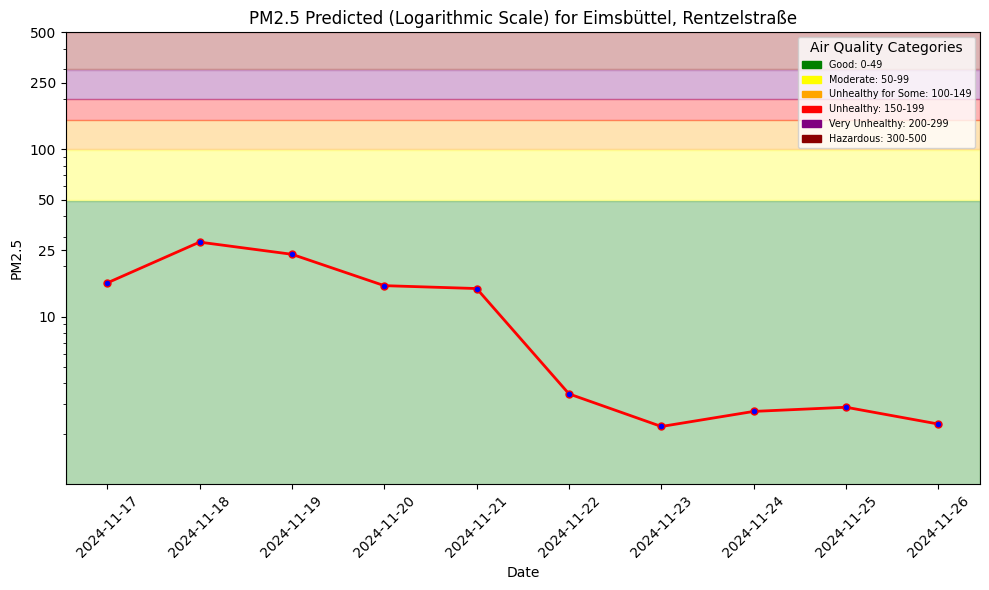

In [21]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

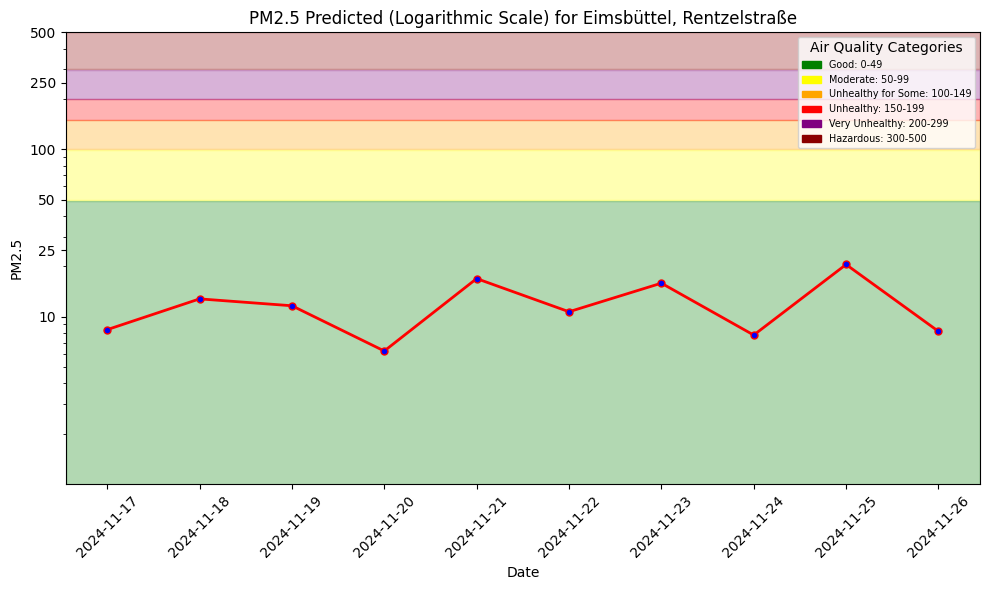

In [22]:
file_path_1 = "../../docs/air-quality/assets/img/pm25_forecast_1.png"
plt_1 = util.plot_air_quality_forecast(city, street, batch_data_1, file_path_1)
plt_1.show()

In [23]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=3,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [ ]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

In [24]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.90s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-15 00:00:00+00:00,10.65,0.0,15.496736,272.662933,Eimsbüttel,39.393002,Rentzelstraße,Germany,1
1,2024-11-11 00:00:00+00:00,8.10,0.9,11.183201,176.308685,Eimsbüttel,25.624510,Rentzelstraße,Germany,1
2,2024-11-08 00:00:00+00:00,7.20,0.0,20.188908,121.138908,Eimsbüttel,9.671005,Rentzelstraße,Germany,1
3,2024-11-12 00:00:00+00:00,8.75,0.0,9.000000,36.869991,Eimsbüttel,28.691530,Rentzelstraße,Germany,1
4,2024-11-13 00:00:00+00:00,7.75,0.1,9.885262,236.888641,Eimsbüttel,34.856110,Rentzelstraße,Germany,1
5,2024-11-14 00:00:00+00:00,10.65,0.0,17.826363,313.363464,Eimsbüttel,39.806038,Rentzelstraße,Germany,1
6,2024-11-16 00:00:00+00:00,8.95,0.0,21.767351,235.784241,Eimsbüttel,24.093836,Rentzelstraße,Germany,1
7,2024-11-17 00:00:00+00:00,7.45,0.3,23.141029,264.644257,Eimsbüttel,25.323112,Rentzelstraße,Germany,1


### Version 1 ###

In [28]:
# Get or create feature group
monitor_fg_1 = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [29]:
monitor_fg_1.insert(batch_data_1, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/10 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization


RestAPIError: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/1160345/jobs/aq_predictions_1_offline_fg_materialization/executions). Server response: 
HTTP code: 400, HTTP reason: Bad Request, body: b'{"errorCode":130040,"usrMsg":"Parallel executions quota reached for Project: annysiad Current 5 Max: 5","devMsg":"Parallel executions quota reached for Project: annysiad Current 5 Max: 5","errorMsg":"Job reached the maximum number of executions."}', error code: 130040, error msg: Job reached the maximum number of executions., user msg: Parallel executions quota reached for Project: annysiad Current 5 Max: 5

In [26]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df_1 = monitor_fg_1.filter(monitor_fg_1.days_before_forecast_day == 1).read()
monitoring_df_1

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.97s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-08 00:00:00+00:00,7.80,0.0,19.011953,108.778130,Eimsbüttel,14.642779,Rentzelstraße,Germany,1
1,2024-11-07 00:00:00+00:00,6.20,0.0,3.415260,108.435043,Eimsbüttel,10.379901,Rentzelstraße,Germany,1
2,2024-11-15 00:00:00+00:00,10.65,0.0,15.496736,272.662933,Eimsbüttel,12.060919,Rentzelstraße,Germany,1
3,2024-11-11 00:00:00+00:00,8.10,0.9,11.183201,176.308685,Eimsbüttel,12.874387,Rentzelstraße,Germany,1
4,2024-11-12 00:00:00+00:00,8.75,0.0,9.000000,36.869991,Eimsbüttel,6.611174,Rentzelstraße,Germany,1
5,2024-11-13 00:00:00+00:00,7.75,0.1,9.885262,236.888641,Eimsbüttel,14.618913,Rentzelstraße,Germany,1
6,2024-11-14 00:00:00+00:00,10.65,0.0,17.826363,313.363464,Eimsbüttel,8.083456,Rentzelstraße,Germany,1


## Making the feature groups ##

In [33]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=3,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.89s) 


,date,pm25,pm25_lagging,country,city,street,url
0,2020-11-10 00:00:00+00:00,46.520000,42.506668,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758
1,2020-08-21 00:00:00+00:00,13.740000,11.223333,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758
2,2023-03-05 00:00:00+00:00,3.600000,3.473333,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758
3,2023-07-31 00:00:00+00:00,5.600000,6.013333,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758
4,2020-12-19 00:00:00+00:00,17.799999,19.150000,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758
...,...,...,...,...,...,...,...
1788,2024-11-13 00:00:00+00:00,44.000000,40.666668,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758
1789,2024-11-14 00:00:00+00:00,44.000000,44.000000,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758
1790,2024-11-15 00:00:00+00:00,44.000000,44.000000,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758
1791,2024-11-16 00:00:00+00:00,44.000000,44.000000,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758


In [34]:
air_quality_fg_1 = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df_1 = air_quality_fg_1.read()
air_quality_df_1

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.83s) 


,date,pm25,country,city,street,url
0,2020-11-10 00:00:00+00:00,46.520000,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758
1,2020-08-21 00:00:00+00:00,13.740000,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758
2,2023-03-05 00:00:00+00:00,3.600000,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758
3,2023-07-31 00:00:00+00:00,5.600000,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758
4,2020-12-19 00:00:00+00:00,17.799999,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758
...,...,...,...,...,...,...
1793,2024-11-13 00:00:00+00:00,44.000000,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758
1794,2024-11-14 00:00:00+00:00,44.000000,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758
1795,2024-11-15 00:00:00+00:00,44.000000,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758
1796,2024-11-16 00:00:00+00:00,44.000000,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758


In [35]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model, fs)
hindcast_df

,date,predicted_pm25,pm25
2,2024-11-08 00:00:00+00:00,9.671005,34.0
1,2024-11-11 00:00:00+00:00,25.624510,44.0
3,2024-11-12 00:00:00+00:00,28.691530,44.0
4,2024-11-13 00:00:00+00:00,34.856110,44.0
5,2024-11-14 00:00:00+00:00,39.806038,44.0
0,2024-11-15 00:00:00+00:00,39.393002,44.0
6,2024-11-16 00:00:00+00:00,24.093836,44.0
7,2024-11-17 00:00:00+00:00,25.323112,44.0


In [36]:
outcome_df_1 = air_quality_df_1[['date', 'pm25']]
preds_df_1 =  monitoring_df_1[['date', 'predicted_pm25']]

hindcast_df_1 = pd.merge(preds_df_1, outcome_df_1, on="date")
hindcast_df_1 = hindcast_df_1.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df_1) == 0:
    hindcast_df_1 = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df_1, monitor_fg_1, retrieved_xgboost_model_1, fs)
hindcast_df_1

,date,predicted_pm25,pm25
1,2024-11-07 00:00:00+00:00,10.379901,39.0
0,2024-11-08 00:00:00+00:00,14.642779,43.0
3,2024-11-11 00:00:00+00:00,12.874387,44.0
4,2024-11-12 00:00:00+00:00,6.611174,44.0
5,2024-11-13 00:00:00+00:00,14.618913,44.0
6,2024-11-14 00:00:00+00:00,8.083456,44.0
2,2024-11-15 00:00:00+00:00,12.060919,44.0


In [37]:
hindcast_df_merged = pd.merge(hindcast_df_1, hindcast_df, on="date")
hindcast_df_merged = hindcast_df_merged.sort_values(by=['date'])

hindcast_df_merged

,date,predicted_pm25_x,pm25_x,predicted_pm25_y,pm25_y
0,2024-11-08 00:00:00+00:00,14.642779,43.0,9.671005,34.0
1,2024-11-11 00:00:00+00:00,12.874387,44.0,25.624510,44.0
2,2024-11-12 00:00:00+00:00,6.611174,44.0,28.691530,44.0
3,2024-11-13 00:00:00+00:00,14.618913,44.0,34.856110,44.0
4,2024-11-14 00:00:00+00:00,8.083456,44.0,39.806038,44.0
5,2024-11-15 00:00:00+00:00,12.060919,44.0,39.393002,44.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

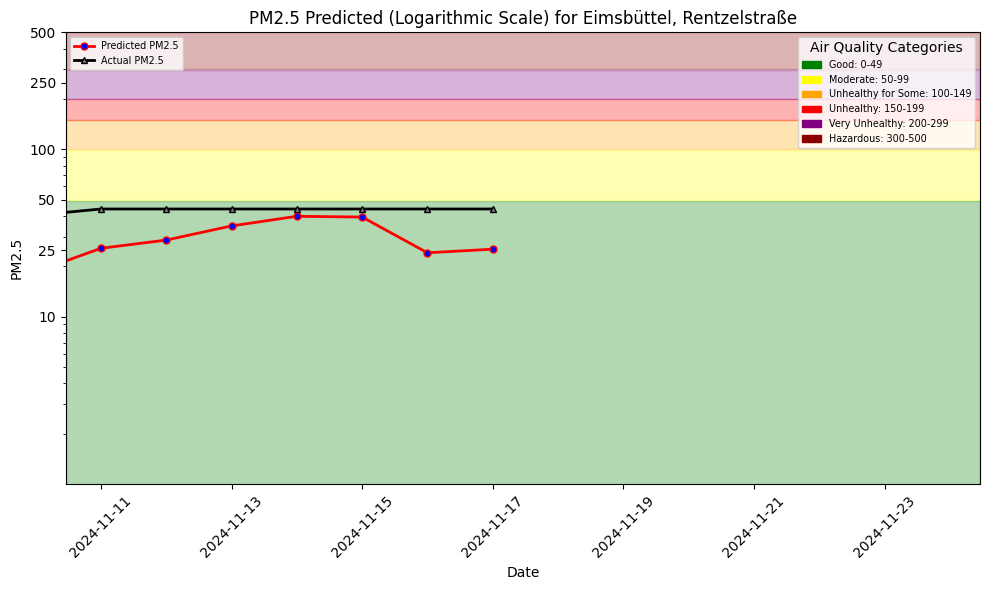

In [38]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

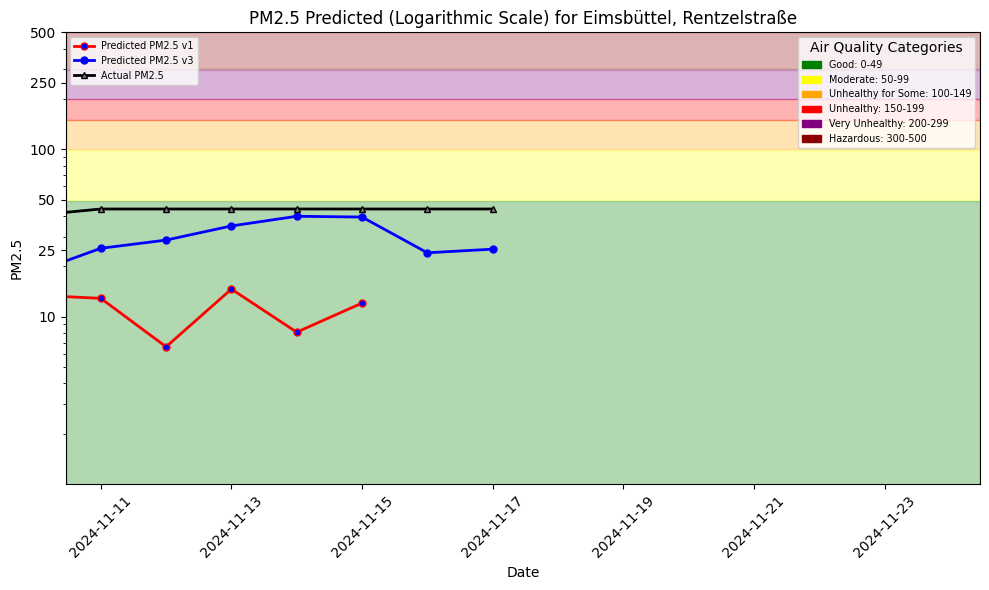

In [41]:
import importlib
importlib.reload(util)

file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day_1.png"
plt = util.plot_air_quality_forecast_merge(city, street, hindcast_df_1, hindcast_df, file_path, hindcast=True)
plt.show()

---